# Upwelling Detection Model Using the 'Speed' (wind) Variable

In [1]:
import pandas as pd
from pathlib import Path
import xarray as xr
import numpy as np
import calendar
import os.path
from dateutil.relativedelta import relativedelta
import tensorflow as tf

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Dense, Masking
from tensorflow.keras.models import Model
from tqdm.keras import TqdmCallback

import seaborn as sns
from matplotlib import pyplot as plt

2023-07-21 22:37:19.621567: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-21 22:37:19.672790: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-21 22:37:19.673962: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-21 22:37:20.485849: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


This chunks load our data from the zarr file. Our zarr file contains various varibale, and in this notebook we focus on the 'speed' variable for wind to detect upwelling. You can also test the 'direction' variable which is also for wind and has the same logic.

In [2]:
zarr_ds = xr.open_zarr(store='/home/jovyan/shared/data/INDIAN_OCEAN_025GRID_DAILY.zarr', consolidated=True)
zarr_ds

<xarray.Dataset>
Dimensions:          (time: 16071, lat: 177, lon: 241)
Coordinates:
  * lat              (lat) float32 32.0 31.75 31.5 31.25 ... -11.5 -11.75 -12.0
  * lon              (lon) float32 42.0 42.25 42.5 42.75 ... 101.5 101.8 102.0
  * time             (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2022-12-31
Data variables: (12/19)
    CHL              (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_uncertainty  (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    adt              (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    air_temp         (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    curr_dir         (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    curr_speed       (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    ...               ...
    ug_curr          (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    v_curr           (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    v_wind           (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    vg_curr          (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    wind_dir         (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    wind_speed       (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
Attributes: (12/17)
    creator_email:              minhphan@uw.edu
    creator_name:               Minh Phan
    creator_type:               person
    date_created:               2023-07-19
    geospatial_lat_max:         32.0
    geospatial_lat_min:         -12.0
    ...                         ...
    geospatial_lon_units:       degrees_east
    source:                     Earth & Space Research (ESR), Copernicus Clim...
    summary:                    Daily mean of 0.25 x 0.25 degrees gridded dat...
    time_coverage_end:          2022-12-31T23:59:59
    time_coverage_start:        1979-01-01T00:00:00
    title:                      Climate Data for Coastal Upwelling Machine Le...

Here we want our data to be in a specific bounding box:

* **lat = slice(35, -5)**
* **lon = slice(45,90)**

zarr_new will only contains the data fall in this bounding box.

In [3]:
zarr_new = zarr_ds.sel(lat=slice(35, -5), lon=slice(45,90))

This function creates a map associating dates within a specified range to normalized data values. Here's a breakdown:

**Function Definition:**

* create_data_map(variable_name, start_date='2010-01-01', end_date='2022-12-31')

* variable_name: The variable in the dataset to process.
start_date: The starting date for the desired range (default is '2010-01-01').
* end_date: The ending date for the desired range (default is '2022-12-31').

Since our label files cannot cover some time ranges, we skip them in the data creation process.

**For each date in the date_range:**

* Skip processing if the date lies within any skip_ranges.
* If the date is present in zarr_dates, retrieve data for that date.
* **Normalize the data by subtracting the mean.**
* **Convert any NaN values to 0.0 (Our model cannot take NaN values as input).**

After defined the `create_data_map` function, we use `data_map = create_data_map('wind_speed')` to create a python dictionary, with dates as keys and speed data as values, you can also use `data_map = create_data_map('wind_dir')` to get the direction data map by **just changing the variable name** here.

In [4]:
def create_data_map(variable_name, start_date='2010-01-01', end_date='2022-12-31'):
    date_range = pd.date_range(start=start_date, end=end_date)

    zarr_dates = pd.to_datetime(zarr_new.time.values)

    # times we don't have labels
    skip_ranges = [
        pd.date_range(start='1983-04-01', end='1983-04-30'),
        pd.date_range(start='1988-02-01', end='1988-02-29'),  # February in a leap year
        pd.date_range(start='1992-09-01', end='1992-09-30'),
        pd.date_range(start='1997-02-01', end='1997-02-28'),
        pd.date_range(start='2001-11-01', end='2001-11-30'),
        pd.date_range(start='2006-04-01', end='2006-04-30'),
        pd.date_range(start='2011-02-01', end='2011-02-28'),
        pd.date_range(start='2015-06-01', end='2015-06-30'),
        pd.date_range(start='2020-02-01', end='2020-02-29')  # February in a leap year
    ]

    date_to_data_map = {}

    for date in date_range:
        if any(date in skip_range for skip_range in skip_ranges):
            continue
        if date in zarr_dates:
            data = getattr(zarr_new, variable_name).sel(time=str(date.date())).values
            if not np.all(np.isnan(data)):
                mean_val = np.nanmean(data)
                normalized_day_data = data - mean_val
                normalized_day_data = np.nan_to_num(normalized_day_data, nan=0.0)

                date_to_data_map[date] = normalized_day_data

    return date_to_data_map

data_map = create_data_map('wind_speed')

The function `get_labels` processes SST (Sea Surface Temperature) difference datasets for a given date range. It extracts specific entries from each dataset and assigns labels based on a predefined threshold.

**Function Definition:**

`start_date` and `end_date` specify the range of dates for which datasets will be processed.

**Date Conversion:**

Both input dates are converted to the pandas datetime format for processing.

**Data Processing Loop:**
The function processes data for each month in the specified date range. For each month:

* A file path is constructed based on the current date.
If the dataset for that month doesn't exist, the function skips to the next month.

* The dataset is loaded and converted to a pandas DataFrame.
Entry IDs are assigned for each data point within a specific date.
Data points with entry IDs **22** and **23** are filtered out and labeled based on the SST_Diff column. Please check the notebook **01_Data.ipynb** for more information of the point indexes.

* Labels for each date are then aggregated; if both entries for a date have a label of 1, the aggregate label is 1; otherwise, it's 0.
Thresholding and Labeling:

* Entries are labeled as 1 if their SST_Diff value is less than -1; otherwise, they're labeled as 0.

**Results:**

The function returns a Series of aggregated labels for the entire date range.

In [5]:
def get_labels(start_date, end_date):
    # Convert input dates to datetime format
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # List to store all group labels
    all_labels = pd.Series(dtype=int)

    # Initialize current date to start_date
    curr_date = start_date

    while curr_date <= end_date:
        year = curr_date.year
        month = curr_date.month

        file_name = f"/home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/{year}{month:02d}_sst_diff.nc"
        if not Path(file_name).exists():
            print(f"File {file_name} does not exist, skipping...")
            curr_date += relativedelta(months=1)
            continue
        print(f"Processing file {file_name}...")

        # Open the dataset and convert it to a pandas DataFrame
        temp = xr.open_dataset(file_name)
        temp_df = temp.to_dataframe()

        # Convert the 'time' column to date only format
        temp_df.index = pd.to_datetime(temp_df.index).date

        # Reset index to create 'time' column
        temp_df = temp_df.reset_index()

        # Create a new column 'entry_id' which enumerates each entry within each date
        temp_df['entry_id'] = temp_df.groupby('time').cumcount()

        # Filter dataframe for rows where 'entry_id' is 22 and 23, and create a copy
        filtered_df = temp_df[temp_df['entry_id'].isin([22,23])].copy()

        # Create a label column - set to 1 if SST_Diff < threshold, else set to 0
        threshold = -1
        filtered_df.loc[:, 'label'] = np.where(filtered_df['SST_Diff'] < threshold, 1, 0)

        # Group by 'time' and check if all 'label' in a group is 1, if so, set group_label to 1, else 0
        group_labels = filtered_df.groupby('time')['label'].apply(lambda x: 1 if x.sum() == 2 else 0)

        # Append the group_labels to all_labels
        all_labels = pd.concat([all_labels, group_labels])

        # Move to the next month
        curr_date += relativedelta(months=1)

    print(all_labels.shape)
    return all_labels

# Call the function with your specific start and end date
labels = get_labels('2010-01-01', '2022-12-31')

Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/201001_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/201002_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/201003_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/201004_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/201005_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/201006_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/201007_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/201008_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/201009_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/201010_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0

Here we filtered the labels with dates contained in the dataset.

In [6]:
valid_dates = list(data_map.keys())
filtered_labels = labels[labels.index.isin(valid_dates)]

We then make sure the labels and data are of the same shape.

In [7]:
assert len(data_map) == len(filtered_labels)

This line of code reshapes the filtered_labels pandas Series into a **one-dimensional numpy array**. The values attribute of the pandas Series is used to obtain the data in the form of a numpy array, and the ravel() function is then applied to this array to flatten it.

In [8]:
all_labels_reshaped = filtered_labels.values.ravel()

Here, we first convert the data_map dictionary into a numpy array, then adding one additional dimension for it for our model to process it. Then we do the train_test_split which randomly splits **80%** of the data for training, and the rest **20%** for testing. A random seed (random_state=42) ensures **reproducibility**.

In [15]:
X = np.array(list(data_map.values()))

X = np.expand_dims(X, axis=-1)

X_train, X_test, y_train, y_test = train_test_split(X, all_labels_reshaped, test_size=0.2, random_state=42)

We want to obtain our input shape for our model, so we access a single data entry from the data_map and obtain its shape. Since all of our data are of the same shape, that shape is the input shape for our model.

In [16]:
sample_data = next(iter(data_map.values()))
input_shape = (sample_data.shape[0], sample_data.shape[1], 1)

This line of code defines the base of a machine learning model using the **EfficientNetB0 architecture**, which is part of the Keras Applications module and is a popular choice for image-related tasks.

Here's a breakdown of the parameters:

* `include_top=False` means that the final layer of the model, which is typically responsible for class prediction in the pre-trained version of the model, is not included. This allows a new top layer, appropriate for the current task, to be added later.

* `weights=None` indicates that the model will be initialized without pre-trained weights. This means the model will be trained from scratch. This is because the model was trained on the ImageNet dataset (a dataset of natural objects), thus it's not suitbale for us to obtain those weights for our remote-sensing data which is quite different from natural objects.

* input_shape=(processed_data.shape[1], processed_data.shape[2], 1) sets the shape of the input data that the model will receive. In this case, the input shape matches the dimensions of the SST data, with an additional channel dimension.

In [17]:
# Define the model
base_model = EfficientNetB0(include_top=False, weights=None, input_shape=input_shape)

This section of code customizes the base EfficientNetB0 model for a specific task by **adding a new top layer** to it.

* The base model's output is first taken and passed through a **GlobalAveragePooling2D layer**, which performs spatial average pooling operation, reducing the spatial dimensions (height and width) of input feature map while preserving the depth. This operation helps to reduce the number of parameters and computation in the network, and hence to also control overfitting.

* **A fully connected (Dense) layer** of 1024 units with ReLU (Rectified Linear Unit) activation function is added next. This layer can learn complex patterns from the pooled features.

* Finally, **a logistic layer**, which is another Dense layer with a single unit and a sigmoid activation function, is added. This layer serves as the output layer of the model and outputs the final prediction. The sigmoid function squishes the output values between 0 and 1, which can be treated as a probability for binary classification tasks.

The Keras Model class is then used to define the complete model, taking the base model's input as its input and the newly added logistic layer's output as its output.

* The model is compiled with the '**Adam'** optimizer, a commonly used optimizer that adjusts the learning rate adaptively for different parameters. The loss function is set as 'binary_crossentropy', which is suitable for binary classification tasks. The metric used for model evaluation during training is accuracy.

* A **TqdmCallback** is defined to display a progress bar during model training.

* The model is then trained for **50 epochs** using the fit method. The training data (X_train, y_train) and the TqdmCallback are passed as arguments. The verbose parameter is set to 0, which means no training information will be printed to the console, but the progress is shown by TqdmCallback.

* After training, the model's performance is evaluated on the test data (X_test, y_test) using the evaluate method. The method returns the final loss and accuracy on the test data.

Finally, the accuracy of the model on the test data is printed to the console. This provides an indication of how well the model will likely perform on unseen data, assuming that the test data is a representative sample.

In [18]:
# Add a global spatial average pooling layer
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# Add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# And a logistic layer
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

tqdm_callback = TqdmCallback(verbose=1)

# Train the model
model.fit(X_train, y_train, epochs=50, verbose=0, callbacks=[tqdm_callback])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy}")

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

27/27 [==============================] - 7s 201ms/step - loss: 0.2759 - accuracy: 0.9640
Accuracy: 0.9640371203422546


After our model is trained, we want to make predictions for all data in our dataset, here is the summary for this chunk:
* Loops through each entry in data_map to retrieve associated data.
Pre-processes each data entry to replace NaN values and adjusts its shape for model compatibility.

* Uses our trained model to predict outcomes based on the pre-processed data.

* Collects each **date**, **actual value**, and **corresponding prediction** into a list.

* Converts this list into a DataFrame df to easily compare actual values against model predictions.

Finally, the resulting DataFrame is printed for inspection.

In [10]:
data = []  # List to store each row of the DataFrame

# Iterate through all dates in date_to_data_map
for date, day_data in data_map.items():
    actual_val = filtered_labels[date]
        
    # Pre-process the day data and predict
    day_data = np.nan_to_num(day_data, nan=0.0)  # Replace NaN with 0
    day_data = np.expand_dims(day_data, axis=(0, -1))  # Add a new dimension for the batch and channel

    prediction = model.predict(day_data, verbose=0)

    # Append the data for the current date to the list
    data.append({'time': date, 'actual_val': actual_val, 'predicted_val': prediction[0][0]})

# Create a DataFrame from the data list
df = pd.DataFrame(data)

# Check the DataFrame
print(df)

           time  actual_val  predicted_val
0    2010-01-01           0   5.193201e-07
1    2010-01-02           0   3.738628e-06
2    2010-01-03           0   7.608469e-07
3    2010-01-04           0   5.596061e-06
4    2010-01-05           0   2.505242e-07
...         ...         ...            ...
4302 2022-12-27           0   5.483035e-07
4303 2022-12-28           0   9.187638e-08
4304 2022-12-29           0   3.778959e-07
4305 2022-12-30           0   2.431139e-05
4306 2022-12-31           0   6.293625e-07

[4307 rows x 3 columns]


Set a threshold of **0.5** and see the results:

In [12]:
print(len(df[(df['actual_val'] == 0) & (df['predicted_val'] > 0.5)]))
print(len(df[(df['actual_val'] == 0)]))
print(len(df[(df['actual_val'] == 1) & (df['predicted_val'] > 0.5)]))
print(len(df[(df['actual_val'] == 1)]))

9
3790
490
517


Make a histogram visualization to observe the whole distribution.

/tmp/ipykernel_44/2030461022.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group0, bins=20, kde=False, norm_hist=True, label='Actual_val 0')
/tmp/ipykernel_44/2030461022.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group1, bins=20, kde=False, norm_hist=True, label='Actual_val 1')


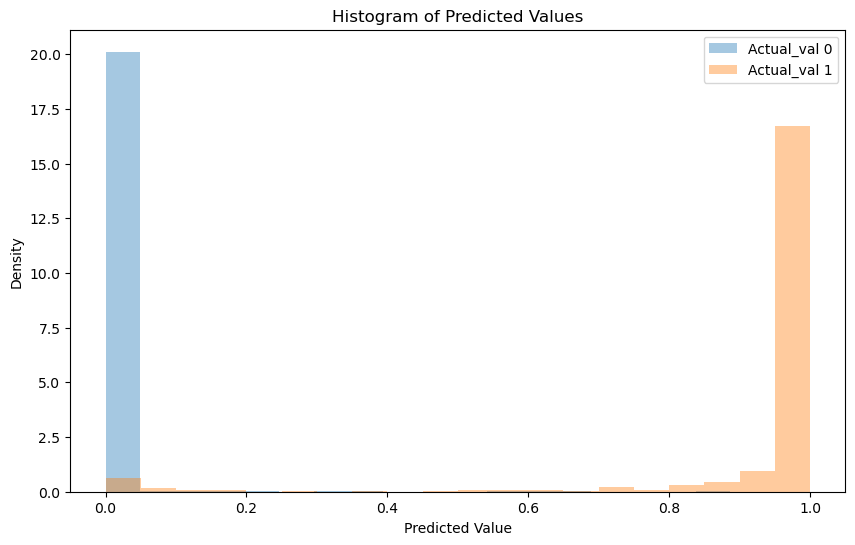

In [21]:
# Convert 'predicted_val' to float
df['predicted_val'] = df['predicted_val'].apply(lambda x: float(x[0]) if isinstance(x, (list, np.ndarray)) else float(x))

# Separate the data into two groups based on 'actual_val'
group0 = df[df['actual_val'] == 0]['predicted_val']
group1 = df[df['actual_val'] == 1]['predicted_val']

# Create the histogram plot
plt.figure(figsize=(10, 6))
sns.distplot(group0, bins=20, kde=False, norm_hist=True, label='Actual_val 0')
sns.distplot(group1, bins=20, kde=False, norm_hist=True, label='Actual_val 1')

# Set the labels and title
plt.xlabel('Predicted Value')
plt.ylabel('Density')
plt.title('Histogram of Predicted Values')
plt.legend()

# Show the plot
plt.show()

Save the model as a checkpoint file for later uses. You can load the model and do fine-tunings on it. Here is the code for reloading:

`from tensorflow.keras.models import load_model`

`model = load_model('efficientnet_wind_2010_2022.keras')`

In [22]:
model.save('efficientnet_wind_speed_2010_2022.keras')

Here are functions for us to test the EfficientNet model we've got. The `predict_for_date` function will allow users to input a date and a prediction result will be returned. Please be aware the given date needs to be contained in the data_map. **Notice some days in our zarr file have NaN values, so the input date cannot come from those days.**

In [ ]:
def predict_for_date(input_date):
    # Convert user input to pandas Timestamp
    date_timestamp = pd.Timestamp(input_date)

    # Check if the timestamp is in the data_map
    if date_timestamp not in data_map:
        raise ValueError(f"The date {input_date} is not available in the data map.")

    day_data = data_map[date_timestamp]
    day_data = np.nan_to_num(day_data, nan=0.0)
    day_data = np.expand_dims(day_data, axis=(0, -1))
    prediction = model.predict(day_data)
    return prediction

In [ ]:
date = '1993-01-03'
print(predict_for_date(date))

1/1 [==============================] - 0s 25ms/step
[[2.5376906e-07]]


4307